In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import metrics
from sklearn.compose import make_column_transformer
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

plt.rcParams['font.family']='Malgun Gothic'
plt.rcParams['font.size']=14
import matplotlib
matplotlib.rcParams["font.family"]="Malgun Gothic"
matplotlib.rcParams["axes.unicode_minus"]= False

### 데이터 불러오기

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
print('train shape : ', train.shape)
print('test shape : ', test.shape)

train shape :  (1459, 11)
test shape :  (715, 10)


hour : 시간  
temperature : 기온  
precipitation : 강수여부 0, 1  
windspeed : 풍속 평균  
humidity : 습도  
visibility : 가시성  
ozone : 오존  
pm10 : 미세먼지   
pm2.5 : 초미세먼지

In [5]:
train.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


In [6]:
train.drop('id', axis = 1, inplace=True)
test.drop('id', axis = 1, inplace=True)

### EDA

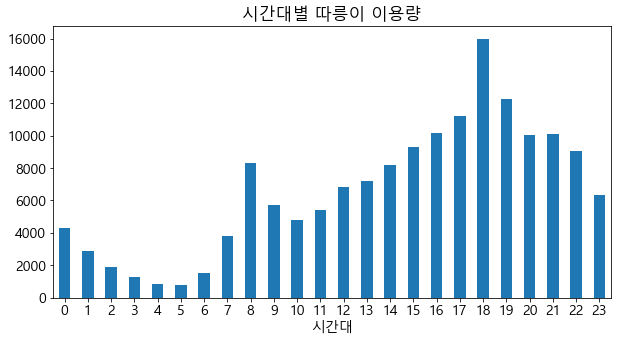

In [7]:
# 시간대별 이용량
plt.figure(figsize = (10,5))
plt.title('시간대별 따릉이 이용량')
train.groupby('hour')['count'].sum().plot.bar()
plt.xticks(rotation = 0)
plt.xlabel('시간대')
plt.show()

- 출퇴근 시간 이용량 급증함을 확인 가능

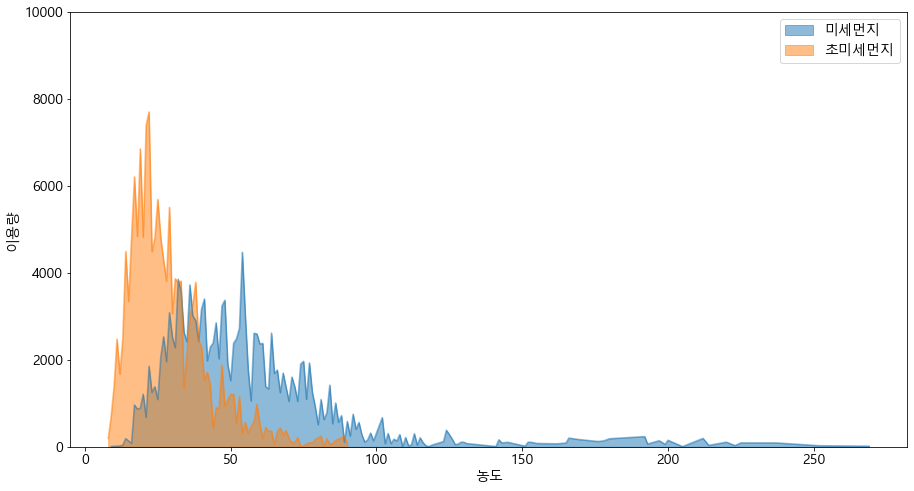

In [8]:
#미세먼지 농도별 이용량
plt.figure(figsize = (15,8))
train.groupby('hour_bef_pm10')['count'].sum().plot.area(label = '미세먼지',stacked=False)
train.groupby('hour_bef_pm2.5')['count'].sum().plot.area(label = '초미세먼지',stacked=False)
plt.xlabel('농도')
plt.ylabel('이용량')
plt.ylim(0,10000)
plt.legend()
plt.show()

- 미세먼지농도가 낮을 때 이용량이 많다.
- 그냥 높은 날이 별로 없어서일 가능성도 있음

In [9]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
hour,1459.0,11.493489,6.922790,0.000,5.5000,11.000,17.500,23.000
hour_bef_temperature,1457.0,16.717433,5.239150,3.100,12.8000,16.600,20.100,30.000
hour_bef_precipitation,1457.0,0.031572,0.174917,0.000,0.0000,0.000,0.000,1.000
hour_bef_windspeed,1450.0,2.479034,1.378265,0.000,1.4000,2.300,3.400,8.000
hour_bef_humidity,1457.0,52.231297,20.370387,7.000,36.0000,51.000,69.000,99.000
hour_bef_visibility,1457.0,1405.216884,583.131708,78.000,879.0000,1577.000,1994.000,2000.000
hour_bef_ozone,1383.0,0.039149,0.019509,0.003,0.0255,0.039,0.052,0.125
hour_bef_pm10,1369.0,57.168736,31.771019,9.000,36.0000,51.000,69.000,269.000
hour_bef_pm2.5,1342.0,30.327124,14.713252,8.000,20.0000,26.000,37.000,90.000
count,1459.0,108.563400,82.631733,1.000,37.0000,96.000,150.000,431.000


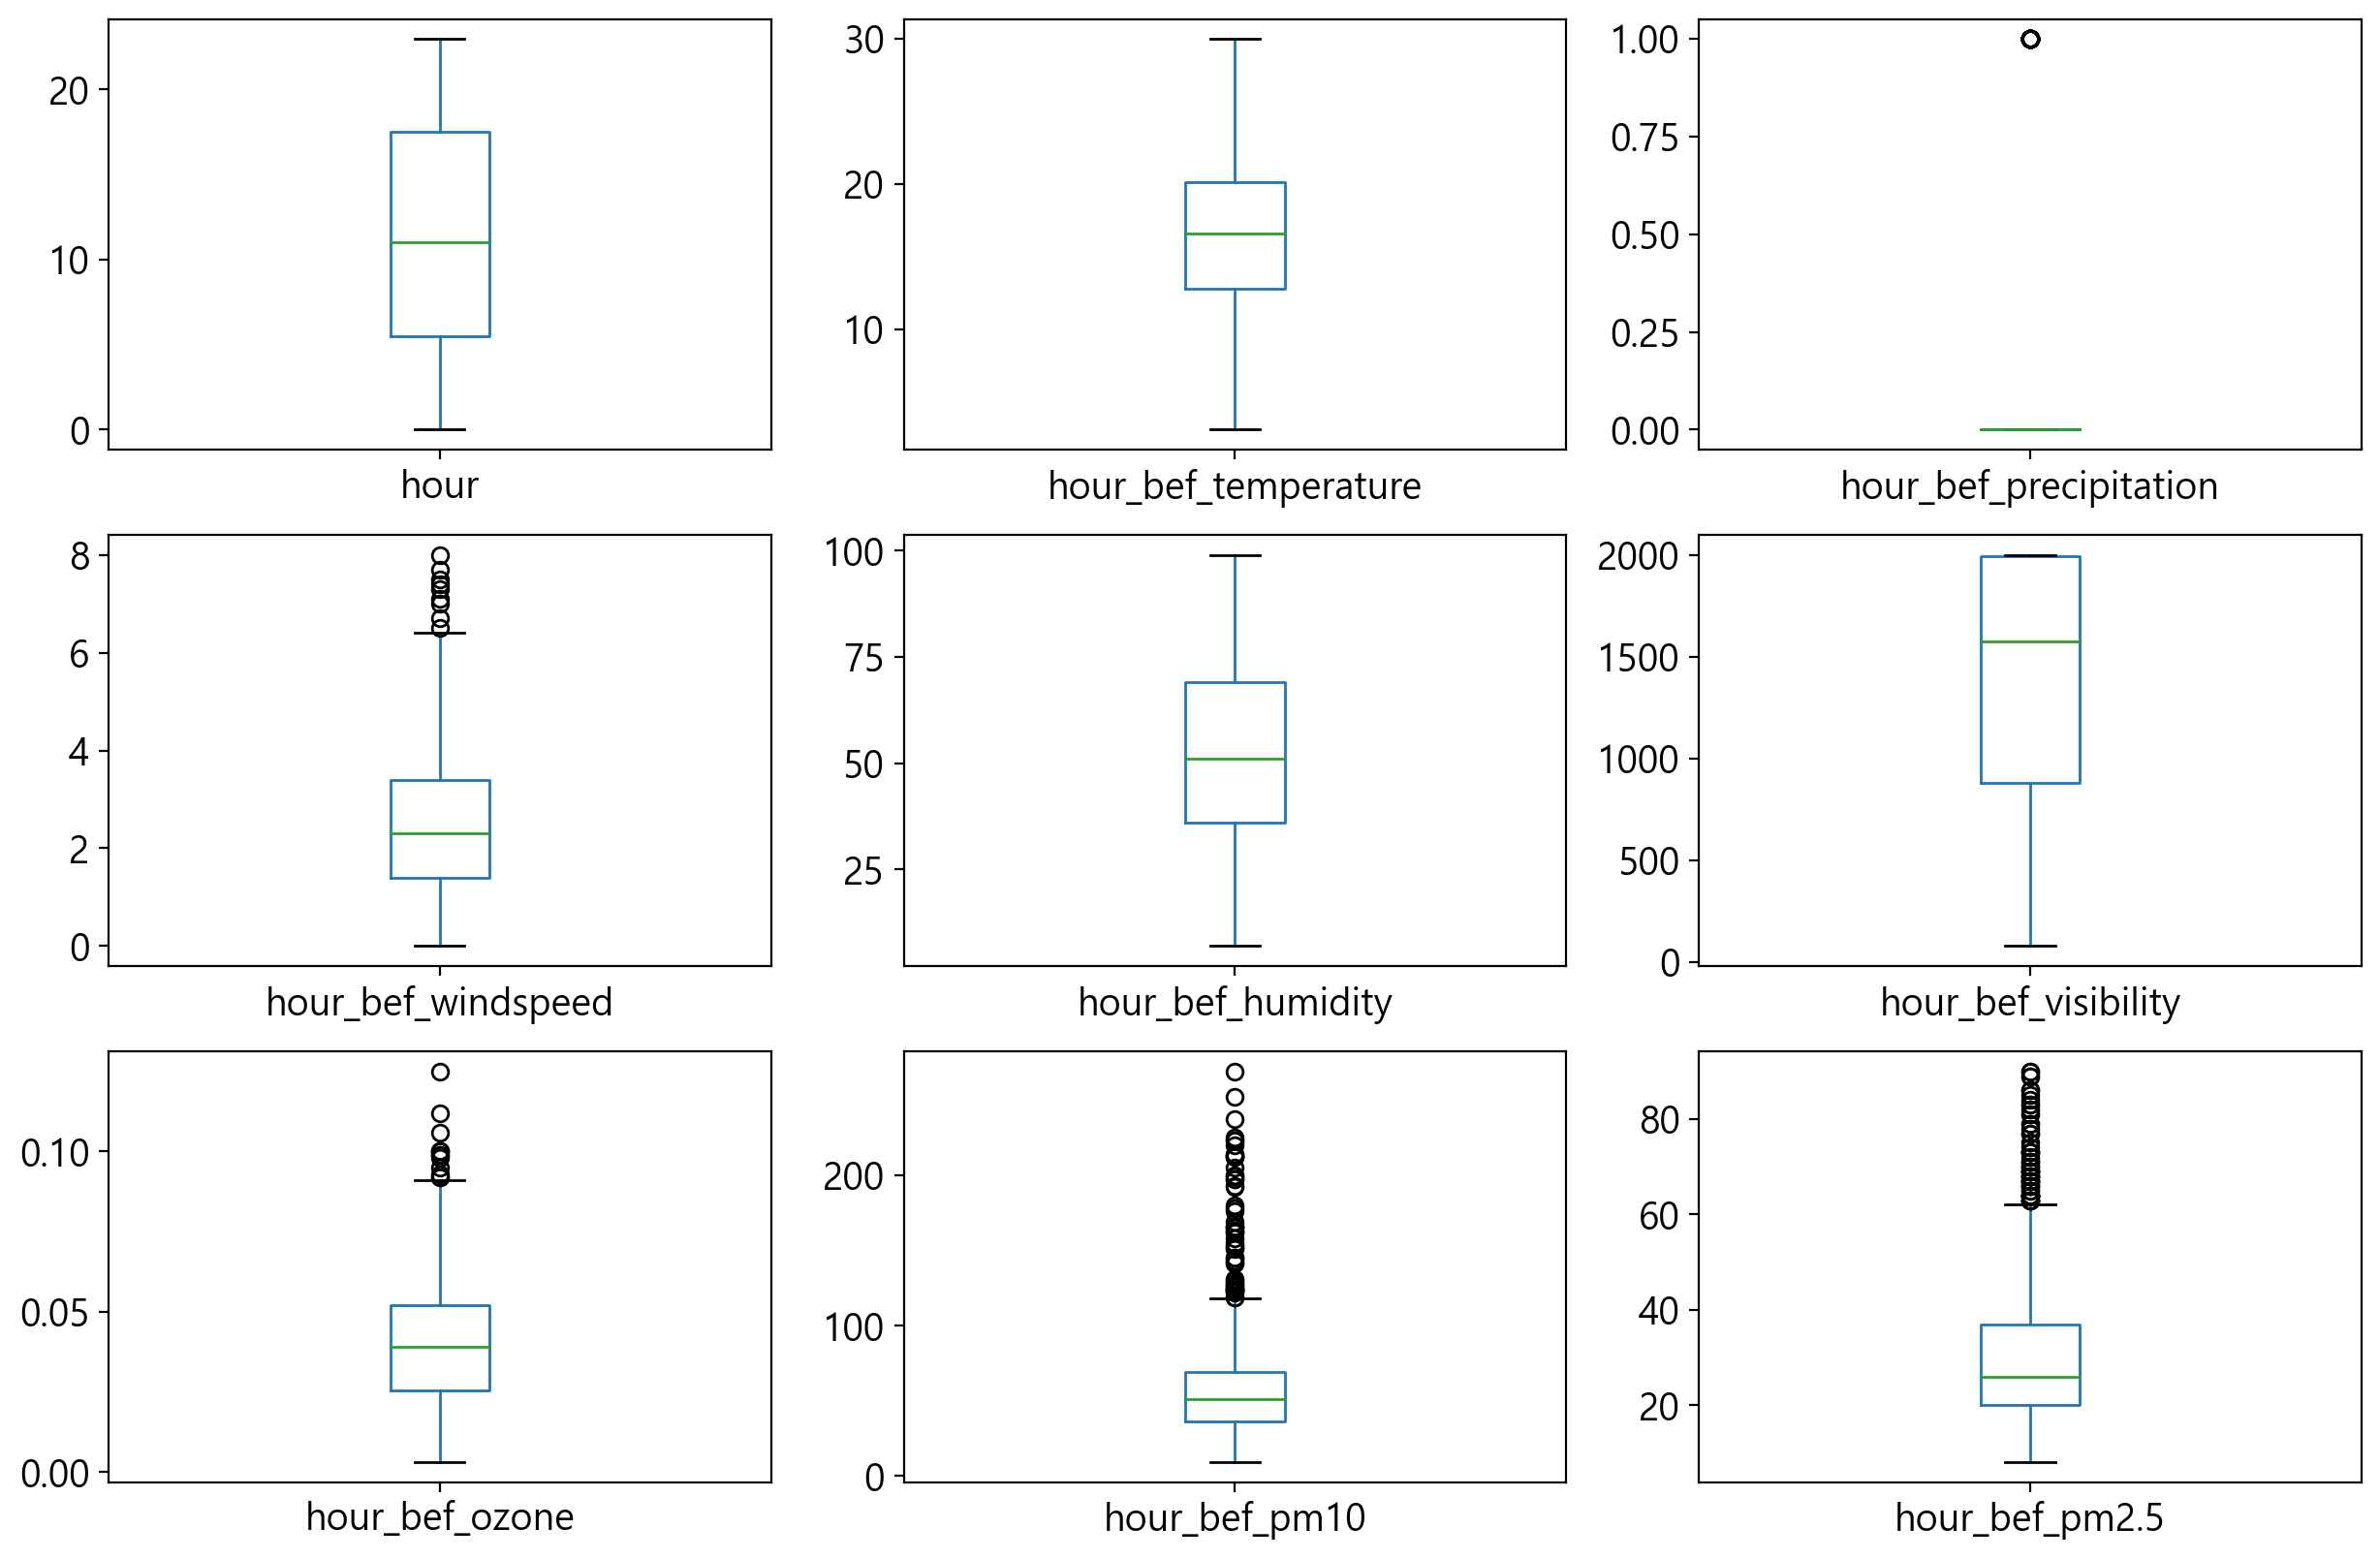

In [10]:
#박스 플롯 확인
fig, ax = plt.subplots(3,3,figsize = (15,10), dpi = 200)
for col,ax in zip(train.columns, ax.flatten()):
    train[col].plot.box(ax =ax)
plt.show()

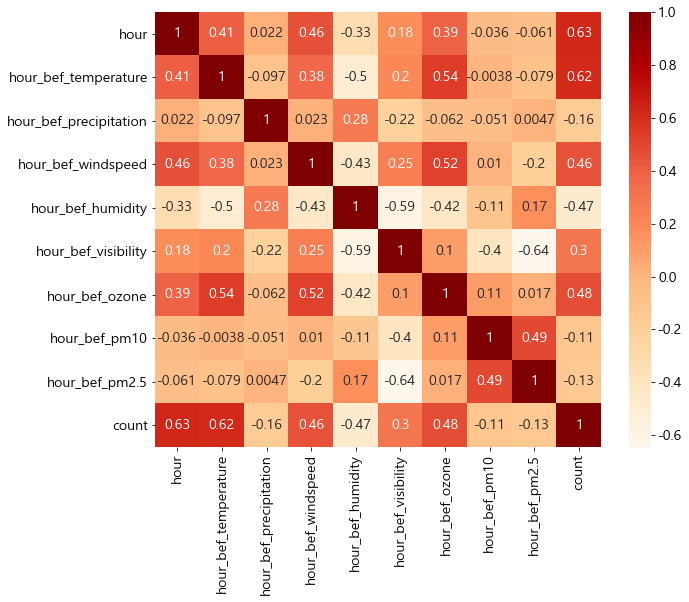

In [11]:
plt.figure(figsize = (10,8))
sns.heatmap(train.corr(), annot = True, cmap = 'OrRd')
plt.show()

- 시간과 온도가 이용량과 가장 밀접한 상관관계를 가짐

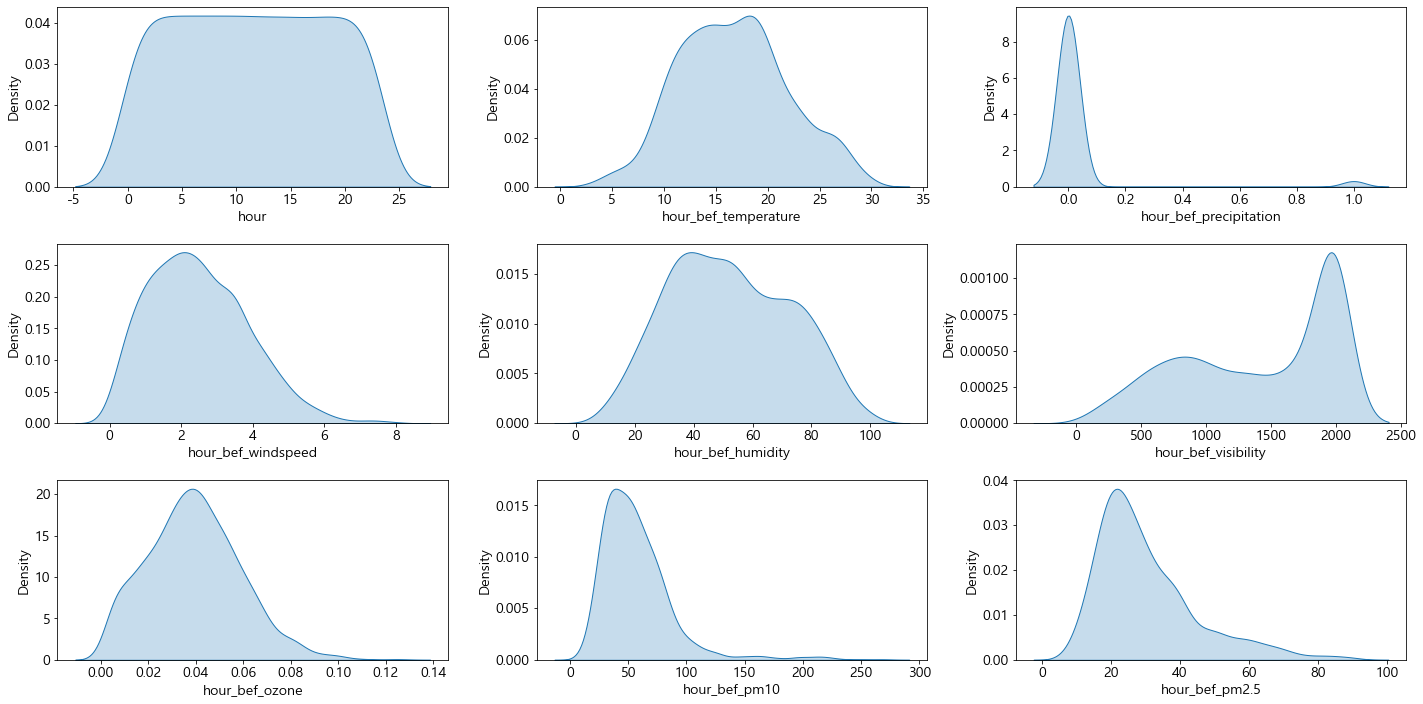

In [12]:
fig, ax = plt.subplots(3,3, figsize = (20,10))

for col , ax in zip(train.columns, ax.flatten()):
    sns.kdeplot(train[col],fill=True, ax = ax)

plt.tight_layout()
plt.show()

### 결측치 처리

In [13]:
train.isna().sum()

hour                        0
hour_bef_temperature        2
hour_bef_precipitation      2
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64

In [14]:
test.isna().sum()

hour                       0
hour_bef_temperature       1
hour_bef_precipitation     1
hour_bef_windspeed         1
hour_bef_humidity          1
hour_bef_visibility        1
hour_bef_ozone            35
hour_bef_pm10             37
hour_bef_pm2.5            36
dtype: int64

In [15]:
#이상치가 많은 미세먼지값은 중간값, 강수유무는 최빈값, 나머지는 평균으로 채움

train_mean  = train[['hour_bef_temperature','hour_bef_windspeed','hour_bef_humidity','hour_bef_visibility']].mean()
train_mode = train['hour_bef_precipitation'].mode()
train_median = train[['hour_bef_ozone','hour_bef_pm10','hour_bef_pm2.5']].median()


train[['hour_bef_temperature','hour_bef_windspeed','hour_bef_humidity','hour_bef_visibility']] = \
    train[['hour_bef_temperature','hour_bef_windspeed','hour_bef_humidity','hour_bef_visibility']].fillna(train_mean)
train[['hour_bef_precipitation']] = train[['hour_bef_precipitation']].fillna(*train_mode)
train[['hour_bef_ozone','hour_bef_pm10','hour_bef_pm2.5']] = train[['hour_bef_ozone','hour_bef_pm10','hour_bef_pm2.5']].fillna(train_median)

test[['hour_bef_temperature','hour_bef_windspeed','hour_bef_humidity','hour_bef_visibility']] = \
    test[['hour_bef_temperature','hour_bef_windspeed','hour_bef_humidity','hour_bef_visibility']].fillna(train_mean)
test[['hour_bef_precipitation']] = test[['hour_bef_precipitation']].fillna(*train_mode)
test[['hour_bef_ozone','hour_bef_pm10','hour_bef_pm2.5']] = test[['hour_bef_ozone','hour_bef_pm10','hour_bef_pm2.5']].fillna(train_median)

In [16]:
print(train.isna().sum().sum())
print(test.isna().sum().sum())

0
0


### 미세먼지 관련 피쳐 생성

미세먼지(pm10) :  좋음 0\~30 보통\~80 나쁨\~150 매우나쁨 151\~   
초미세먼지(pm2.5) : 좋음 0\~15 보통\~35 나쁨\~75 매우나쁨 76\~   
좋음 1, 보통 2, 나쁨 3 ,매우나쁨 4  

In [17]:
train['pm10'] = ['좋음' if x <= 30 else '보통' if x <= 80 else '나쁨' if x <= 150 else '매우나쁨' for x in train['hour_bef_pm10']]
train['pm2.5'] = ['좋음' if x <= 15 else '보통' if x <= 35 else '나쁨' if x <= 75 else '매우나쁨' for x in train['hour_bef_pm2.5']]

test['pm10'] = ['좋음' if x <= 30 else '보통' if x <= 80 else '나쁨' if x <= 150 else '매우나쁨' for x in test['hour_bef_pm10']]
test['pm2.5'] = ['좋음' if x <= 15 else '보통' if x <= 35 else '나쁨' if x <= 75 else '매우나쁨' for x in test['hour_bef_pm2.5']]

생성된 피쳐를 원핫인코딩

In [18]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
ohe.fit(train[['pm10','pm2.5']])

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [19]:
train_onehot = pd.DataFrame( ohe.transform(train[['pm10','pm2.5']]) , columns=ohe.get_feature_names()  )
test_onehot =  pd.DataFrame( ohe.transform(test[['pm10','pm2.5']]) , columns=ohe.get_feature_names()  )

In [20]:
train = pd.concat([train.drop(['pm10','pm2.5'], axis = 1),train_onehot], axis = 1)
test = pd.concat([test.drop(['pm10','pm2.5'], axis = 1),test_onehot], axis = 1)

미세먼지 수치값을 제거하는 쪽이 점수가 더 높았다.

In [21]:
train.drop(['hour_bef_pm10','hour_bef_pm2.5'], axis = 1 , inplace = True)
test.drop(['hour_bef_pm10','hour_bef_pm2.5'], axis = 1 , inplace = True)

## 시간 주기함수
- 시간을 주기값으로 바꾸면 보통 성능 향상된다

In [22]:
train['hour_sin'] = np.sin(2 * np.pi * train['hour']/24.0)
train['hour_cos'] = np.cos(2 * np.pi * train['hour']/24.0)

test['hour_sin'] = np.sin(2 * np.pi * test['hour']/24.0)
test['hour_cos'] = np.cos(2 * np.pi * test['hour']/24.0)

train.drop('hour', axis = 1, inplace=True)
test.drop('hour', axis = 1, inplace=True)

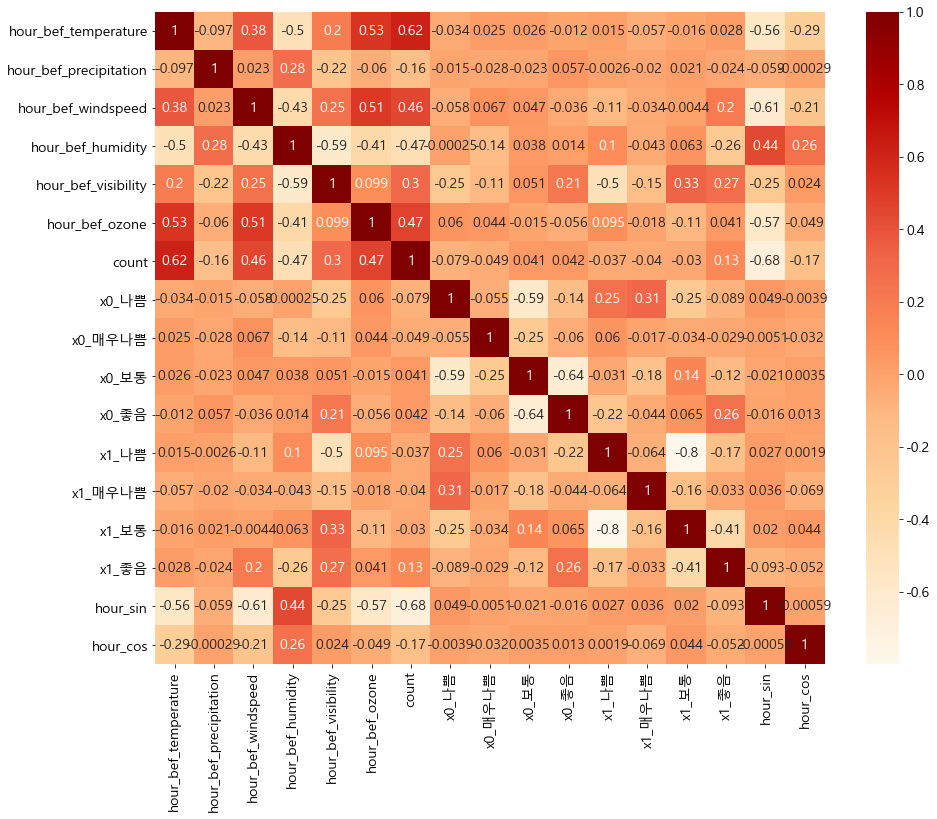

In [23]:
plt.figure(figsize = (15,12))
sns.heatmap(train.corr(), annot = True, cmap = 'OrRd')
plt.show()

In [24]:
#최종 train data 확인
train.head()

,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,count,x0_나쁨,x0_매우나쁨,x0_보통,x0_좋음,x1_나쁨,x1_매우나쁨,x1_보통,x1_좋음,hour_sin,hour_cos
0,16.3,1.0,1.5,89.0,576.0,0.027,49.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-0.866025,5.000000e-01
1,20.1,0.0,1.4,48.0,916.0,0.042,159.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-0.258819,-9.659258e-01
2,13.9,0.0,0.7,79.0,1382.0,0.033,26.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.000000,6.123234e-17
3,8.1,0.0,2.7,54.0,946.0,0.040,57.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,-0.258819,9.659258e-01
4,29.5,0.0,4.8,7.0,2000.0,0.057,431.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-1.000000,-1.836970e-16


## 모델

In [37]:
x_data = train.drop('count',axis = 1)
target = train['count']
scl = StandardScaler()

In [26]:
#lgbm
lgbm = LGBMRegressor()

#5개의 폴드로 교차검증
kfold = KFold(n_splits=5, shuffle=True, random_state=2020)

각 폴드별로 만들어진 모델별로 test score를 계산해 평균으로 모델을 평가하고  
최종 예측은 각 모델로 예측된 값의 평균으로 한다.

In [27]:
lgb_scores = []
lgb_models = []
for train_idx,test_idx in kfold.split(train):
    x_train,x_test  = x_data.iloc[train_idx] , x_data.iloc[test_idx]
    y_train,y_test =  y_data.iloc[train_idx], y_data.iloc[test_idx]
    
    model_lgbm = make_pipeline(scl,lgbm)
    model_lgbm.fit(x_train, y_train,
                 lgbmregressor__eval_set=[(x_test, y_test)],
                 lgbmregressor__eval_metric='rmse',
                 lgbmregressor__verbose=100,
                  )
    
    
    lgb_models.append(model_lgbm)
    lgb_scores.append(metrics.mean_squared_error(y_test, model_lgbm.predict(x_test))**0.5)

[100]	valid_0's rmse: 56.9885	valid_0's l2: 3247.69
[100]	valid_0's rmse: 64.6237	valid_0's l2: 4176.22
[100]	valid_0's rmse: 61.0208	valid_0's l2: 3723.54
[100]	valid_0's rmse: 62.7782	valid_0's l2: 3941.1
[100]	valid_0's rmse: 65.2041	valid_0's l2: 4251.58


In [28]:
#kfold 평균 test rmse
np.mean(lgb_scores)

40.02909246009467

In [29]:
#fold모델끼리 softvoting 앙상블
lgb_preds = []
for model in lgb_models:
    lgb_preds.append(model.predict(test))
    
lgb_final_pred = np.mean(lgb_preds, axis=0)

In [46]:
train_df = train[['hour_cos', 'hour_bef_temperature', 'hour_bef_windspeed', 'hour_bef_precipitation', 'hour_bef_humidity']]
test_df = test[['hour_cos', 'hour_bef_temperature', 'hour_bef_windspeed', 'hour_bef_precipitation', 'hour_bef_humidity']]

In [47]:
## 현재 최고 점수 모델(model_xgb_grid8_fs.csv)
model_xgb = Pipeline( [ ('scl', StandardScaler()), ('xgb', XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.05,
                              max_delta_step=0, max_depth=17, min_child_weight=1.5,
                              monotone_constraints='()',
                              n_estimators=300, n_jobs=12, num_parallel_tree=1,
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=0.5,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None)) ] )
model_xgb.fit(train_df, target)

Pipeline(steps=[('scl', StandardScaler()),
                ('xgb',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.05,
                              max_delta_step=0, max_depth=17,
                              min_child_weight=1.5, missing=nan,
                              monotone_constraints='()', n_estimators=300,
                              n_jobs=12, num_parallel_tree=1, random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=0.5, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

In [48]:
submission = pd.read_csv('data/submission.csv')
submission['count'] = model_xgb.predict(test_df)
submission

,id,count
0,0,126.302879
1,1,253.131363
2,2,84.009575
3,4,176.266815
4,5,78.873001
...,...,...
710,2148,140.423843
711,2149,64.551567
712,2165,136.638092
713,2166,125.420464


In [42]:
submission.to_csv('xgbdefault_dustonehotdelorigin_sincos_5kfoldensemble.csv', index=False)